# Extracting etrics from text using DaCy and TextDescriptives


<a target="_blank" href="https://colab.research.google.com/github/centre-for-humanities-computing/DaCy/blob/main/textdescriptives_integration.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

DaCy allows you to use other packages in the spaCy universe as you normally would - just powered by the DaCy models.

The following tutorial shows you how to use DaCy and [TextDescriptives](https://github.com/HLasse/TextDescriptives/) to extract a variety of metrics from text. For more information on the metrics that can be extracted, see the [TextDescriptives documentation](https://hlasse.github.io/TextDescriptives/index.html).


## Data
In this tutorial we'll use TextDescriptives and DaCy, to get a quick overview of the [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).
The dataset contains 5572 SMS messages categorized as ham or spam. 

To start, let's load a dataset and get a bit familiar with it.

In [1]:
from textdescriptives.utils import load_sms_data

df = load_sms_data()
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

## Adding TextDescriptives components to DaCy

Adding TextDescriptives components to a DaCy pipeline, follows exactly the same procedure as for any spaCy model. Let's add the `readability` and `dependency_distance` components. `Readability` is a component that calculates readability metrics, and `dependency_distance` is a component that calculates the average dependency distance between words in a sentence. This can be seen a measure of sentence complexity.

Because we are using a DaCy model, the `dependency_distance` component will use the dependency parser from DaCy for its calculations.

In [3]:
import dacy
nlp = dacy.load("da_dacy_medium_trf-0.1.0")

nlp.add_pipe("textdescriptives/readability")
nlp.add_pipe("textdescriptives/dependency_distance")

/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'da_dacy_medium_trf' (0.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'da_dacy_small_trf' (0.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy_tran

ℹ 'textdescriptives/descriptive_stats' component is required for
'textdescriptives.readability'. Adding to pipe.


From now on, whenever we pass a document through the pipeline (`nlp`), TextDescriptives will add readability and dependency distance metrics to the document.

Let's load the data and pass it through the pipeline.

In [4]:
# to speed things up (especially on cpu) let's subsample the data
df = df.sample(500)

doc = nlp.pipe(df["message"])

In [5]:
import textdescriptives as td
# extract the metrics as a dataframe
metrics = td.extract_df(doc, include_text=False)

/Users/au561649/.virtualenvs/dacy/lib/python3.10/site-packages/spacy/pipeline/attributeruler.py:150: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [6]:
# join the metrics to the original dataframe
df = df.join(metrics, how="left")
df.head()

,label,message,flesch_reading_ease,flesch_kincaid_grade,smog,gunning_fog,automated_readability_index,coleman_liau_index,lix,rix,...,sentence_length_median,sentence_length_std,syllables_per_token_mean,syllables_per_token_median,syllables_per_token_std,n_tokens,n_unique_tokens,proportion_unique_tokens,n_characters,n_sentences
2417,ham,Oh... Lk tt den we take e one tt ends at cine ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4746,ham,"When you just put in the + sign, choose my num...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,ham,HI BABE IM AT HOME NOW WANNA DO SOMETHING? XX,85.096667,2.715,3.1291,2.133333,-1.100833,0.7,17.833333,0.666667,...,5.0,2.054805,1.375,1.0,0.484123,16.0,16.0,1.0,63.0,3.0
5501,spam,PRIVATE! Your 2003 Account Statement for 07808...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5313,ham,My sister going to earn more than me da.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That's it! Let's do a bit of exploratory data analysis to get to know the data a bit more.

## Exploratory Data Analysis
With the metrics extracted, let's do some quick exploratory data analysis to get a sense of the data. Let us start of by taking a look at the distribution of the readability metrics, `lix`.

<AxesSubplot: xlabel='label', ylabel='lix'>

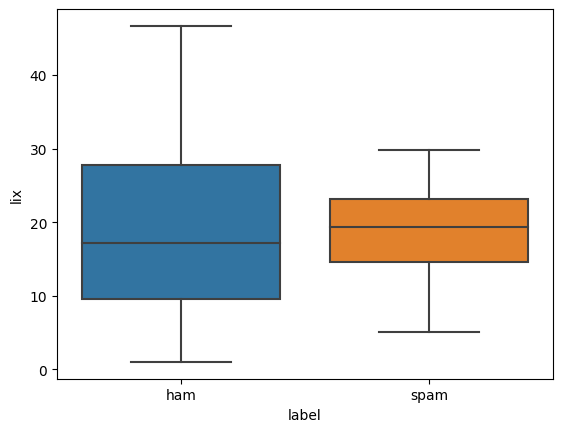

In [10]:
import seaborn as sns
sns.boxplot(x="label", y="lix", data=df)

Let's run a quick test to see if any of our metrics correlate strongly with the label

In [8]:
# encode the label as a boolean
df["is_ham"] = df["label"] == "ham"
# compute the correlation between all metrics and the label
metrics_correlations = metrics.corrwith(df["is_ham"]).sort_values(key=abs, ascending=False)
metrics_correlations[:10]

prop_adjacent_dependency_relation_std    -0.403782
dependency_distance_mean                  0.364726
prop_adjacent_dependency_relation_mean    0.280266
proportion_unique_tokens                 -0.244895
sentence_length_median                    0.222776
token_length_median                      -0.197070
sentence_length_mean                      0.196973
dependency_distance_std                  -0.178205
sentence_length_std                      -0.170378
syllables_per_token_mean                 -0.169208
dtype: float64

That's some pretty high correlations! Notably we see that the mean dependency distance is correlated with `ham`. This makes sense, as the dependency distance is a measure of sentence complexity, and spam messages tend to be shorter and simpler.

Let's try to plot it:

<AxesSubplot: xlabel='dependency_distance_mean', ylabel='Density'>

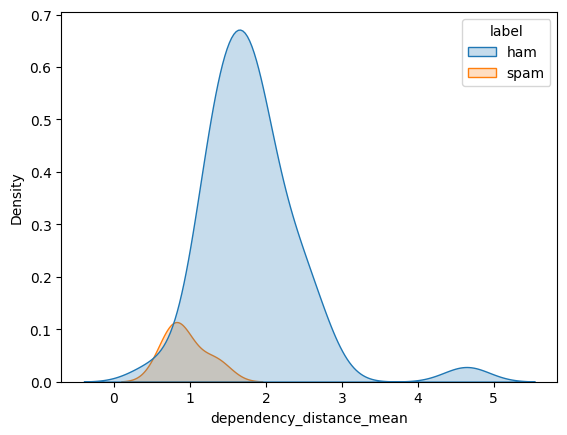

In [17]:
sns.kdeplot(df, x="dependency_distance_mean", hue="label", fill=True)

We can do a similar thing for the `lix` score, where we see that here isn't a big difference between the two classes:

<AxesSubplot: xlabel='lix', ylabel='Density'>

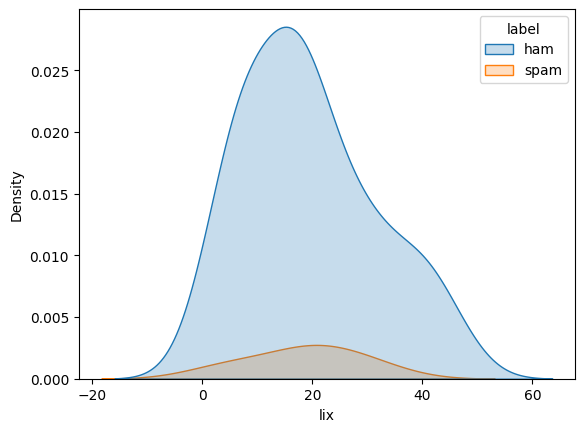

In [18]:
sns.kdeplot(df, x="lix", hue="label", fill=True)

Cool! We've now done a quick analysis of the SMS dataset and found some differences in the distributions of some readability and dependency-distance metrics between the actual SMS's and spam. 

Next steps could be continue the exploratory data analysis or to build a simple classifier using the extracted metrics.